# PROYECTO FINAL ANALISIS PARA SERVICIO DE TELECOMUNICACIONES

*****************************************

# OBJETIVO:

Identificación de operadores menos eficaces con el fin de que los supervisores tengan esta información y poder así tomar acciones para mejorar el servicio de telefonía.

# Enlace a PDF con la presentacion

https://drive.google.com/file/d/1vInRJqwZAMxRASzCHN5QPyiUi1WO6S1I/view?usp=sharing


# Enlace al Dashboard

https://public.tableau.com/views/Dashboardproyectofinal_17589260153300/Histogramaparaladuraciondelasllamadas?:language=es-ES&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link


# Cargar librerias y lectura de datos

In [107]:
# Librerias
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import os

In [2]:
# Lectura de datos
datos = pd.read_csv('/datasets/telecom_dataset_us.csv')
clientes = pd.read_csv('/datasets/telecom_clients_us.csv')

In [3]:
# Visualizacion de los datos
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [4]:
clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [5]:
datos.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [6]:
clientes.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


# Preprocesamiento de datos

Se realizara una limpieza de los datos obtenidos de la base de datos, verificando que no tengan datos duplicados, valores ausentes y que todas las variables tengan el tipo de dato necesario para poder hacer el analisis sin tener ningun inconveniente y disminuyendo los errores causados por los valores ausentes y duplicados.

## Revisar filas duplicadas

In [7]:
# Verificacion de filas duplicadas en datos
datos.duplicated().sum()

4900

In [8]:
# Verificacion de filas duplicadas en clientes
clientes.duplicated().sum()

0

In [9]:
# Eliminar las filas duplicadas en datos
datos.drop_duplicates(inplace=True)

In [10]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49002 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              49002 non-null  int64  
 1   date                 49002 non-null  object 
 2   direction            49002 non-null  object 
 3   internal             48892 non-null  object 
 4   operator_id          41546 non-null  float64
 5   is_missed_call       49002 non-null  bool   
 6   calls_count          49002 non-null  int64  
 7   call_duration        49002 non-null  int64  
 8   total_call_duration  49002 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.4+ MB


## Revisar valores ausentes

In [11]:
# Revision de los valores ausentes
datos.isna().sum()

user_id                   0
date                      0
direction                 0
internal                110
operator_id            7456
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [12]:
print("Porcentaje de valores ausentes en operator_id: {:.2f}".format((datos['operator_id'].isna().sum()/len(datos))*100),'%')
print("\nPorcentaje de valores ausentes en internal: {:.2f}".format((datos['internal'].isna().sum()/len(datos))*100),'%')

Porcentaje de valores ausentes en operator_id: 15.22 %

Porcentaje de valores ausentes en internal: 0.22 %


In [13]:
clientes.isna().sum()

user_id        0
tariff_plan    0
date_start     0
dtype: int64

Se observan varios valores ausentes en la columna ***operator_id*** de la tabla ***datos***, hay un **15%** de valores ausentes, este es un porcentaje muy alto por lo que no es recomendable eliminaros, van a ser reemplazados por un identificador que indique que en esa parte el operador es desconocido, así se puede incluir en el análisis de los datos de una mejor manera sin perder parte de la información que puede ser importante para hallar a los operadores ineficientes.

En la columna ***internal*** hay tambien algunos valores ausentes pero en este caso son una cantidad menor ***0.22%***, en este caso si se podrian eliminar estas filas ya que no se pierde tanta informacion y no tenemos en el momento la manera de saber si la llamada fue interna para rellenar estos valores.

In [14]:
# Eliminacion de filas con valores ausentes en la tabla datos columna 'internal'
datos.dropna(subset=['internal'], inplace=True)

In [15]:
# Reemplazar valores ausentes en la tabla datos columna 'operator_id'
datos['operator_id'].fillna('unknown', inplace=True)

In [16]:
datos.isna().sum()

user_id                0
date                   0
direction              0
internal               0
operator_id            0
is_missed_call         0
calls_count            0
call_duration          0
total_call_duration    0
dtype: int64

## Revision y correccion de tipos de datos

Cambiar el tipo de dato de ***user_id*** de **int** a **object**, ***internal*** de **object** a **bool**, ***operator_id*** de ***float*** a **str** quitando la parte decimal que tiene y ***date*** de **object** a **datetime** dejando solo la parte de la fecha (AAA-MM-DD).

In [17]:
datos['user_id'] = datos['user_id'].astype(object)
datos['internal'] = datos['internal'].astype(bool)
datos['operator_id'] = datos['operator_id'].astype(str).str.replace('.0', '', regex=False) # quitar la parte decimal de la columna operator_id

In [18]:
datos['date'] = pd.to_datetime(datos['date']).dt.date
datos['date'] = pd.to_datetime(datos['date'])

In [19]:
print(datos['date'].min())
print(datos['date'].max())

2019-08-02 00:00:00
2019-11-28 00:00:00


In [20]:
clientes['date_start'] = pd.to_datetime(clientes['date_start'])

In [21]:
clientes.columns = ['user_id', 'tariff_plan', 'registration_date']

In [22]:
print(clientes['registration_date'].min())
print(clientes['registration_date'].max())

2019-08-01 00:00:00
2019-10-31 00:00:00


Cambiar el tipo de dato de ***user_id*** de **int** a **object** y ***date_start*** de **object** a **datetime** a demas cambiar el nombre de esta columna a ***registration_date*** para que quede mas claro que informacion contiene esta columna.

In [23]:
clientes['user_id'] = clientes['user_id'].astype(object)

# Analisis exploratorio de datos 

En esta parte se realizaran calculos estadisticos basicos para ver como se distribuyen los datos que tenemos y tener una mejor idea de como podemos abordar el analisis de las metricas necesarias para identificar los operadores ineficaces.

## Calculos estadisticos basicos y viasualizaciones graficas de las variables.

In [25]:
# Crear una columna nueva con los datos del tiempo de espera de las llamadas
datos['call_waiting_time'] = datos['total_call_duration'] - datos['call_duration']

In [26]:
datos.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,call_waiting_time
0,166377,2019-08-04,in,False,unknown,True,2,0,4,4
1,166377,2019-08-05,out,True,880022,True,3,0,5,5
2,166377,2019-08-05,out,True,880020,True,1,0,1,1
3,166377,2019-08-05,out,True,880020,False,1,10,18,8
4,166377,2019-08-05,out,False,880022,True,3,0,25,25


In [27]:
# Calculos estadisticos basicos para las columnas con valores numericos
datos.describe()

,calls_count,call_duration,total_call_duration,call_waiting_time
count,48892.000000,48892.000000,48892.000000,48892.000000
mean,16.495214,868.088788,1158.976458,290.887671
std,63.671633,3779.549967,4456.180933,1133.354018
min,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,46.000000,17.000000
50%,4.000000,37.000000,210.000000,55.000000
75%,12.000000,573.000000,902.000000,200.000000
max,4817.000000,144395.000000,166155.000000,46474.000000


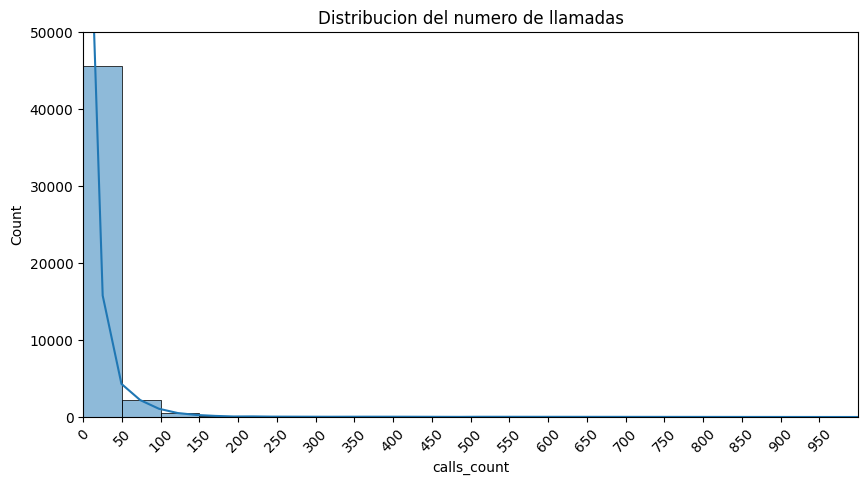

In [28]:
# Histograma para ver la distribucion del numero de llamadas
intervalos_1 = list(range(0, 1000, 50))
plt.figure(figsize=(10, 5))
sns.histplot(datos['calls_count'], bins=intervalos_1, kde=True) 
plt.title('Distribucion del numero de llamadas')
plt.xlim([0, 1000])
plt.ylim([0, 50000])
plt.xticks(range(0, 1000, 50), rotation=45)
plt.show()

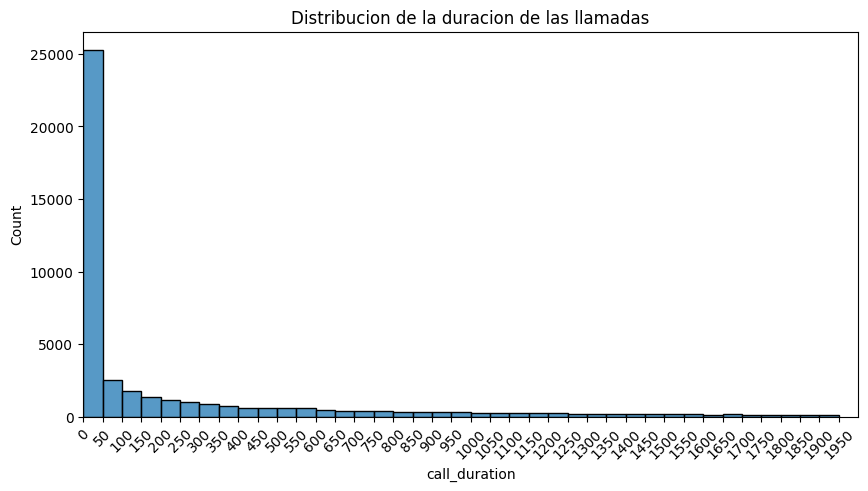

In [29]:
# Histograma para ver la distribucion de la ducracion de las llamadas
intervalos_2 = list(range(0, 2000, 50))
plt.figure(figsize=(10, 5))
sns.histplot(datos['call_duration'], bins=intervalos_2)
plt.title('Distribucion de la duracion de las llamadas')
plt.xlim([0, 2000])
plt.xticks(range(0, 2000, 50), rotation=45)
plt.show()

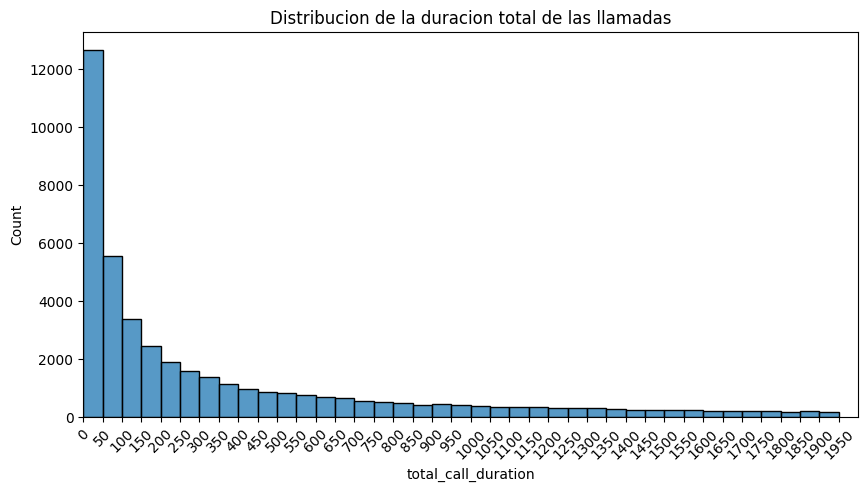

In [30]:
# Histograma para ver la distribucion de la duracion total de las llamadas
plt.figure(figsize=(10, 5))
sns.histplot(datos['total_call_duration'], bins=intervalos_2) 
plt.title('Distribucion de la duracion total de las llamadas')
plt.xlim([0, 2000])
plt.xticks(range(0, 2000, 50), rotation=45)
plt.show()

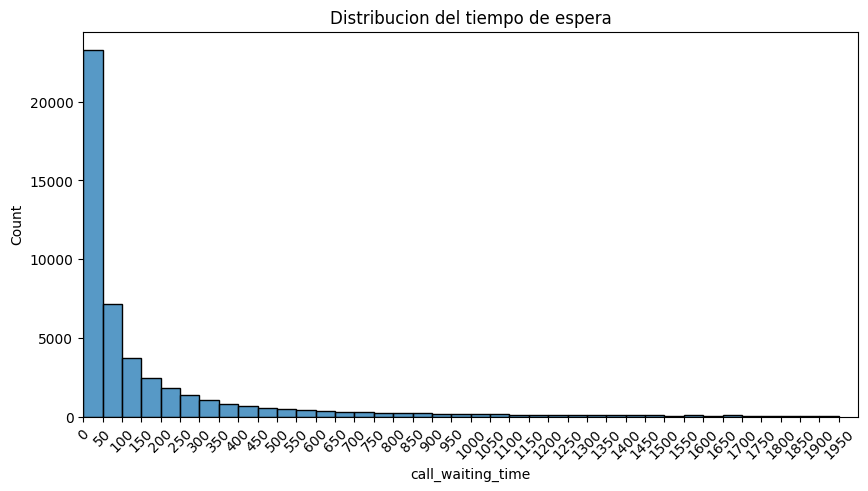

In [31]:
# Histograma para ver la distribucion del tiempo de espera de las llamadas
plt.figure(figsize=(10, 5))
sns.histplot(datos['call_waiting_time'], bins=intervalos_2) 
plt.title('Distribucion del tiempo de espera')
plt.xlim([0, 2000])
plt.xticks(range(0, 2000, 50), rotation=45)
plt.show()

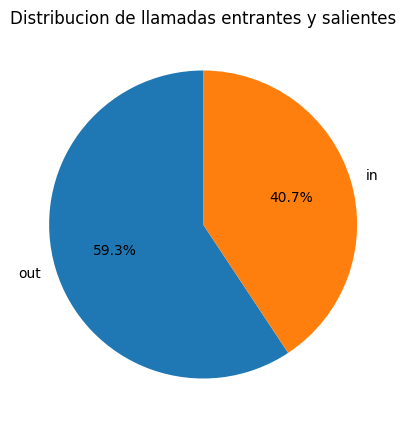

In [32]:
# Diagrama circular para ver la distribucion de llamadas entrantes y salientes
plt.figure(figsize=(5, 5)) 
datos['direction'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribucion de llamadas entrantes y salientes')
plt.ylabel('') # Elimina la etiqueta del eje Y 
plt.show()

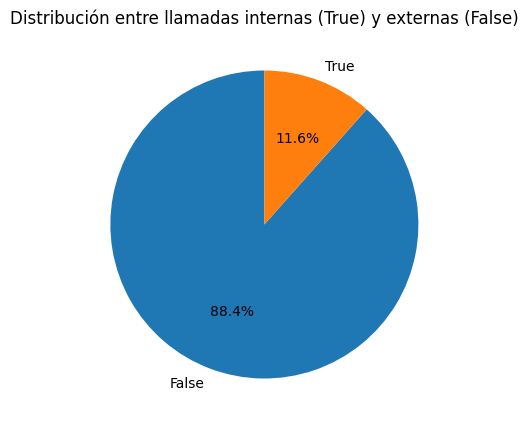

In [33]:
# Diagrama circular para ver la distribucion entre llamadas internas(True) y externas(False)
plt.figure(figsize=(5, 5)) 
datos['internal'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribución entre llamadas internas (True) y externas (False)')
plt.ylabel('') # Elimina la etiqueta del eje Y 
plt.show()

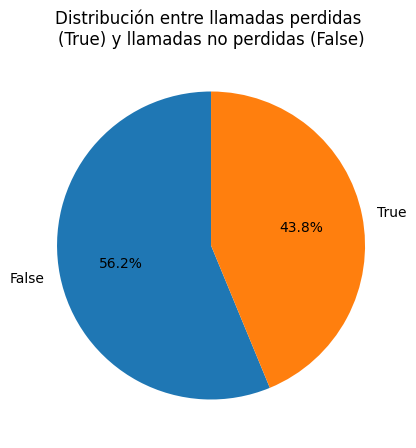

In [34]:
# Diagrama circular para ver la distribucion entre llamadas perdidas(True) y llamadas no perdidas(False)
plt.figure(figsize=(5, 5)) 
datos['is_missed_call'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribución entre llamadas perdidas \n(True) y llamadas no perdidas (False)')
plt.ylabel('') # Elimina la etiqueta del eje Y 
plt.show()

**********************************************
En las gráficas se pueden ver las distribuciones de las variables principales que identifican si un operador es eficaz o ineficaz, en ***número de llamadas***, ***duración de las llamadas***, ***duración total de las llamadas*** y ***tiempo de espera de las llamadas***, se observa que tienen una distribución asimétrica positiva con un sesgo hacia la derecha, lo que significa que la mayoría de los datos están alrededor de cero o valores bajos y se tienen algunos valores atípicos muy altos que podrían ser causados por los operadores ineficaces.

También podemos observamos que hay una ***mayor cantidad*** de ***llamadas salientes*** a comparación de las ***llamadas entrantes***, lo que podría indicar que hay más clientes que necesitan realizar llamadas ya sea para ventas, ofrecer ofertas, cobranzas etc. a sus posibles usuarios, y menos clientes con necesidad de atención al usuario por medio de llamadas entrantes. También en algunas ocasiones los operadores devuelven las llamadas para dar alguna solución al usuario que llamó o continuar con la atención por medio de la llamada ya sea que quedo algo pendiente o se cortó la llamada en medio de la atención.

Para las ***llamadas internas*** o ***externas*** tenemos que ***la mayoría*** de las llamadas son ***externas***, lo que es normal ya que las llamadas internas normalmente se usan para resolver algunas dudas entre los operadores y supervisores o entes administrativos y ejecutivos dentro de la misma empresa, y las llamadas externas son las que se hacen para la atención de los usuarios de los clientes que es uno de los objetivos principales del call center.

En las ***llamadas perdidas*** se observa un alto número de llamadas perdidas con un ***43.8 %*** de llamadas perdidas en total, este es un porcentaje muy alto de llamadas perdidas para el call center, ya que indica que los operadores están siendo ineficaces al contestar las llamadas o que hay algún problema de insuficiencia de operadores, donde entran demasiadas llamadas para el número de operadores que están contestando.

# Identificacion de operadores ineficaces.

En esta parte del análisis se realizará el cálculo de las métricas necesarias para identificar a los operadores ineficaces, se calculará el número de llamadas por operador, número de llamadas entrantes para cada operador, número de llamadas entrantes pérdidas para cada operador, tiempo de espera por operador para las llamadas entrantes y el número de llamadas salientes por operador.

A demás se creará un DataFrame nuevo con los operadores y cada una de estas métricas para poder hacer el análisis e identificar los operadores ineficaces y los eficaces, para esto se va a tener en cuenta que los operadores ineficaces se identifican por tener una alta cantidad de llamadas perdidas, un alto tiempo de espera y muy pocas llamadas salientes.

Para identificar a los operadores ineficientes se usarán los percentiles como un umbral especificado en los que un operador empezaría a ser ineficaz, los operadores se filtraran según este umbral y se separaran en dos grupos operadores eficaces y operadores ineficaces.

In [35]:
# Pasar las columnas de tiempo de llamada a minutos
datos['call_duration'] = datos['call_duration'] / 60
datos['total_call_duration'] = datos['total_call_duration'] / 60
datos['call_waiting_time'] = datos['call_waiting_time'] / 60

In [36]:
# Redondear a 3 cifras de decimales
datos = datos.round(4)

## Numero de llamadas por operador

In [37]:
# Total de llamadas por operador
total_llam_oper = datos.groupby('operator_id')['calls_count'].sum().reset_index().sort_values(by='calls_count', ascending=False)
total_llam_oper.head()

,operator_id,calls_count
1092,unknown,104399
29,885890,60221
28,885876,59429
583,929428,23754
551,925922,20021


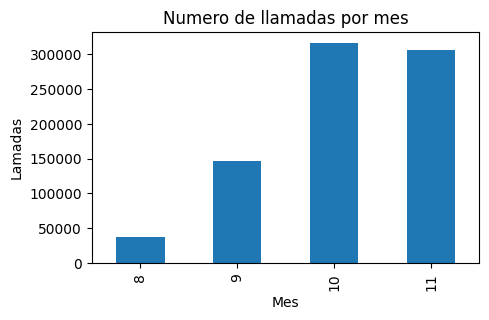

In [38]:
# Grafico de barras con el numero de llamadas en cada mes
plt.figure(figsize=(5, 3))
datos.groupby(datos['date'].dt.month)['calls_count'].sum().plot(kind='bar')
plt.title('Numero de llamadas por mes')
plt.xlabel('Mes')
plt.ylabel('Lamadas')
plt.show()

## Numero de llamadas entrantes por operador

In [39]:
# Df con solo las llamadas entrantes
llamadas_in = datos[datos['direction'] == 'in']

In [40]:
# Numero de llamadas entrantes por operador
num_llam_entr = llamadas_in.groupby('operator_id')['calls_count'].sum().reset_index(name='count_in_calls').sort_values(by='count_in_calls', ascending=False)
num_llam_entr.head()

,operator_id,count_in_calls
754,unknown,103884
288,913938,4766
674,952948,3540
289,913942,2467
76,893804,2433


In [41]:
# Promedio de llamadas entrantes por operador
prom_llam_entr = llamadas_in.groupby('operator_id')['calls_count'].mean().reset_index(name='mean_in_calls').sort_values(by='mean_in_calls', ascending=False)
prom_llam_entr.head()

,operator_id,mean_in_calls
674,952948,110.625000
328,919204,77.666667
326,919166,70.928571
288,913938,61.896104
325,919164,53.833333


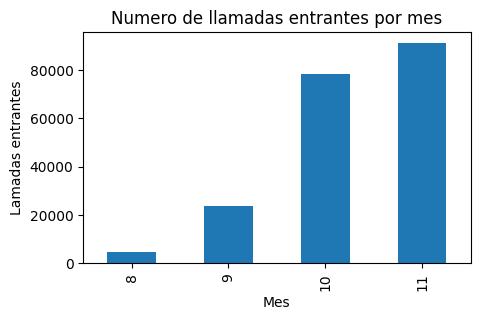

In [42]:
# Grafico de barras con el numero de llamadas entrantes en cada mes
plt.figure(figsize=(5, 3))
llamadas_in.groupby(llamadas_in['date'].dt.month)['calls_count'].sum().plot(kind='bar')
plt.title('Numero de llamadas entrantes por mes')
plt.xlabel('Mes')
plt.ylabel('Lamadas entrantes')
plt.show()

## Numero de llamadas perdidas por operador

In [43]:
# Numero de llamadas entrantes perdidas por operador 
num_llam_perd = llamadas_in.groupby(['operator_id'])['is_missed_call'].sum().reset_index(name='count_missed_calls').sort_values(by='count_missed_calls', ascending=False)
num_llam_perd.head()

,operator_id,count_missed_calls
754,unknown,7149
289,913942,28
22,885890,21
21,885876,17
594,944216,16


In [44]:
# Numero de llamadas perdidas por operador al dia.
num_llam_perd_dia = llamadas_in.groupby(['operator_id', 'date'])['is_missed_call'].sum().reset_index(name='daily_missed_calls').sort_values(by='daily_missed_calls', ascending=False)
num_llam_perd_dia.head()

,operator_id,date,daily_missed_calls
11865,unknown,2019-10-28,121
11896,unknown,2019-11-28,120
11887,unknown,2019-11-19,119
11894,unknown,2019-11-26,118
11888,unknown,2019-11-20,117


In [45]:
# Promedio de llamadas entrantes perdidas por operador
prom_llam_perd = num_llam_perd_dia.groupby('operator_id')['daily_missed_calls'].mean().reset_index(name='mean_missed_calls').sort_values(by='mean_missed_calls', ascending=False)
prom_llam_perd.head()

,operator_id,mean_missed_calls
754,unknown,60.07563
525,937898,1.00000
641,948756,1.00000
698,957922,1.00000
185,904344,1.00000


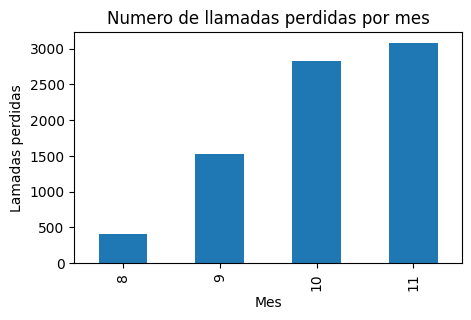

In [46]:
# Grafico de barras con el numero de llamadas entrantes en cada mes
plt.figure(figsize=(5, 3))
llamadas_in.groupby(llamadas_in['date'].dt.month)['is_missed_call'].sum().plot(kind='bar')
plt.title('Numero de llamadas perdidas por mes')
plt.xlabel('Mes')
plt.ylabel('Lamadas perdidas')
plt.show()

## Tiempo de espera en llamadas entrantes para cada operador

In [47]:
# Tiempo de espera para cada operador
tiem_esper = llamadas_in.groupby(['operator_id'])['call_waiting_time'].sum().reset_index(name='waiting_time').sort_values(by='waiting_time', ascending=False)
tiem_esper.head()

,operator_id,waiting_time
754,unknown,21047.9414
335,919790,879.9165
288,913938,676.2838
334,919554,636.6499
333,919552,616.9665


In [48]:
# Tiempo de espera promedio por operador
Tiem_esper_prom = llamadas_in.groupby(['operator_id'])['call_waiting_time'].mean().reset_index(name='mean_waiting_time').sort_values(by='mean_waiting_time', ascending=False)
Tiem_esper_prom.head()

,operator_id,mean_waiting_time
337,919794,16.789584
335,919790,14.913839
206,906070,14.829993
445,931458,11.813994
358,921318,11.050973


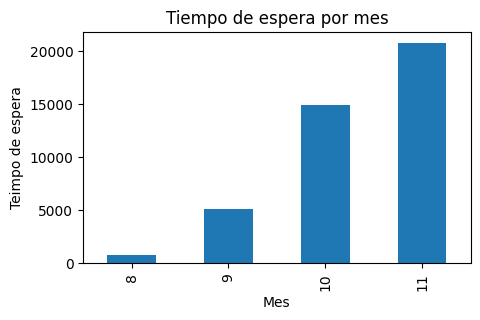

In [49]:
# Grafico de barras con el tiempo de espera en cada mes 
plt.figure(figsize=(5, 3))
llamadas_in.groupby(llamadas_in['date'].dt.month)['call_waiting_time'].sum().plot(kind='bar')
plt.title('Tiempo de espera por mes')
plt.xlabel('Mes')
plt.ylabel('Teimpo de espera')
plt.show()

## Numero de llamadas salientes

In [50]:
# Df con solo las llamadas salientes
llamadas_out = datos[datos['direction'] == 'out']

In [51]:
# Numero de llamadas salientes por operador
num_llam_sali = llamadas_out.groupby('operator_id')['calls_count'].sum().reset_index(name='count_out_calls').sort_values(by='count_out_calls', ascending=False)
num_llam_sali.head()

,operator_id,count_out_calls
25,885890,58977
24,885876,58437
466,929428,23754
446,925922,19603
255,908640,14239


In [52]:
# Promedio de llamadas salientes por operador
prom_llam_sali = llamadas_out.groupby('operator_id')['calls_count'].mean().reset_index(name='mean_out_calls').sort_values(by='mean_out_calls', ascending=False)
prom_llam_sali.head()

,operator_id,mean_out_calls
446,925922,426.152174
25,885890,370.924528
466,929428,365.446154
255,908640,331.139535
24,885876,302.782383


## DataFrame con todas las metricas por operador

In [53]:
# Unir todas las metricas en un solo df con merge
metricas_operador_1 = pd.merge(num_llam_perd, tiem_esper, on='operator_id', how='left')

In [54]:
# Df final con los operadores y sus respectivas metricas
metricas_operador = pd.merge(metricas_operador_1, num_llam_sali, on='operator_id', how='outer')

In [55]:
metricas_operador.head()

,operator_id,count_missed_calls,waiting_time,count_out_calls
0,unknown,7149.0,21047.9414,515.0
1,913942,28.0,492.8835,440.0
2,885890,21.0,188.4331,58977.0
3,885876,17.0,150.2837,58437.0
4,944216,16.0,139.0668,133.0


## Calculo de percentiles para umbran de ineficacia

Calculo de percentiles que servirán como umbral para determinar que operario es ineficaz y cual es eficaz.

In [56]:
# Estadistica basica de metricas_operador para visualizar percentiles 
metricas_operador.describe()

,count_missed_calls,waiting_time,count_out_calls
count,755.000000,755.000000,883.000000
mean,10.374834,55.081139,689.533409
std,260.156831,768.903976,3121.188601
min,0.000000,0.016700,1.000000
25%,0.000000,1.025000,11.000000
50%,0.000000,4.250000,90.000000
75%,1.000000,17.933200,591.500000
max,7149.000000,21047.941400,58977.000000


In [57]:
# Caluclo de percentil umbral de eficiencia llamadas perdidas (los que esten por encima del percentil 95 son ineficaces)
llam_per_sin_nan = metricas_operador['count_missed_calls'].dropna()
percentil_llam_per = np.percentile(llam_per_sin_nan, 95)
print(f"El percentil 95 para llamadas perdidas es: {percentil_llam_per}")

El percentil 95 para llamadas perdidas es: 5.0


In [58]:
# Caluclo de percentil umbral de eficiencia tiempo de espera (los que esten por encima del percentil 85 son ineficaces)
tiem_espe_sin_nan = metricas_operador['waiting_time'].dropna()
percentil_tiem_espe = np.percentile(tiem_espe_sin_nan, 85)
print(f"El percentil 85 para tiempo de espera es: {percentil_tiem_espe}")

El percentil 85 para tiempo de espera es: 39.15503


In [59]:
# Caluclo de percentil umbral de eficiencia llamadas salientes (los que esten por debajo del percentil 60 son ineficaces)
llam_sali_sin_nan = metricas_operador['count_out_calls'].dropna()
percentil_llam_sali = np.percentile(llam_sali_sin_nan, 60)
print(f"El percentil 60 para llamadas salientes es: {percentil_llam_sali}")

El percentil 60 para llamadas salientes es: 196.0


## Filtrar los operadores ineficaces

In [60]:
# Filtro para operadores ineficaces
filtro_ineficaces = (metricas_operador['count_missed_calls'] > 
                   percentil_llam_per) & (metricas_operador['waiting_time'] > 
                                          percentil_tiem_espe) & (metricas_operador['count_out_calls'] < 
                                                                  percentil_llam_sali)

In [61]:
# Filtro para operadores eficaces
filtro_eficaces = (metricas_operador['count_missed_calls'] < 
                   percentil_llam_per) & (metricas_operador['waiting_time'] < 
                                          percentil_tiem_espe) & (metricas_operador['count_out_calls'] > 
                                                                  percentil_llam_sali)

In [62]:
# Encontrar los operadores ineficaces con el filtro
oper_ineficaces = metricas_operador[filtro_ineficaces]

In [63]:
# Encontrar los operadores eficaces con el filtro
oper_eficaces = metricas_operador[filtro_eficaces]

In [64]:
oper_eficaces

,operator_id,count_missed_calls,waiting_time,count_out_calls
50,929424,3.0,27.6500,3963.0
52,900892,3.0,37.2166,933.0
53,940614,3.0,7.8499,426.0
61,912296,3.0,33.3497,483.0
62,947304,3.0,3.4668,645.0
...,...,...,...,...
697,912252,0.0,10.0670,224.0
707,907986,0.0,0.3333,447.0
717,912722,0.0,15.5668,385.0
738,917234,0.0,1.1500,1174.0


In [65]:
oper_ineficaces

,operator_id,count_missed_calls,waiting_time,count_out_calls
4,944216,16.0,139.0668,133.0
5,940588,15.0,110.2665,67.0
6,944226,14.0,127.9830,109.0
9,940630,11.0,135.5331,127.0
10,919554,11.0,636.6499,11.0
12,944218,11.0,149.9331,164.0
13,951508,10.0,106.1000,146.0
21,908960,8.0,270.5665,113.0
22,919206,7.0,122.8169,1.0
26,905104,6.0,85.1834,187.0


In [66]:
oper_ineficaces.describe()

,count_missed_calls,waiting_time,count_out_calls
count,10.0000,10.000000,10.000000
mean,10.9000,188.409920,105.800000
std,3.3483,165.284549,61.755432
min,6.0000,85.183400,1.000000
25%,8.5000,113.404100,77.500000
50%,11.0000,131.758050,120.000000
75%,13.2500,147.216525,142.750000
max,16.0000,636.649900,187.000000


*********************************************************
Se realiza el filtro de operadores ineficaces teniendo en cuenta que cumplan con las tres métricas que indican que un operador es ineficaz que son **alto número de llamadas perdidas**, **tiempo de espera prolongado** y **pocas llamadas salientes**, para esto se tuvo en cuenta la totalidad de los datos después de eliminar las filas duplicadas y tratar los valores ausentes, así que se tiene el cálculo de las métricas para cada operador durante los casi 4 meses para los que se recuperaron los datos de los operadores (**2019-08-02 a 2019-11-28**).

Para identificar un operador como ineficaz se propusieron unos umbrales de eficacia donde los operadores que estén por encima del **percentil 95** para las llamadas perdidas (donde hasta el 95% de los operadores tienen 5 llamadas perdidas o menos en los casi 4 meses), los operadores que estén por encima del **percentil 85** para tiempo de espera (donde hasta el 85% de los operadores tienen 39 minutos de espera o menos en los casi 4 meses) y los operadores que estén por debajo del **percentil 60** para las llamadas salientes (donde hasta el 60% de los operadores tienen 196 llamadas salientes o menos en los casi 4 meses), serían considerados como operadores ineficaces.

Se obtuvo una lista de operadores ineficaces bastante reducida donde el mínimo de llamadas perdidas es de 6 y el máximo de 16, el mínimo de tiempo de espera son 85 minutos y el máximo es 636 minutos y el mínimo de llamadas salientes es 1 y el máximo son 187 llamadas salientes.

Es una lista bastante reducida, y se está teniendo en cuenta que el operador cumpla con la ineficacia en las 3 métricas, se podría hacer un análisis más minucioso donde, verifiquemos que métrica es más importante para tenerla más en cuenta y cual es menos importante o separar los operadores que deben hacer llamadas salientes según su cargo y cuales no para analizarlos en grupos separados, pero para esto tendríamos que tener un poco más clara la información de cuál es la función principal del operador para saber si entre sus obligaciones esta hacer llamadas salientes o no, para así poder clasificarlos y separarlos de una mejor manera.

Se deja como recomendación incluir la función principal del operador en la base de datos para hacer un análisis más minucioso con respecto a las llamadas salientes que realizan los operadores y así poder identificar si está siendo ineficaz al tener bajas llamadas salientes o si es normal que no tenga llamadas salientes o tenga pocas.

In [67]:
# Duracion de las llamadas en operadores desconocidos
datos[datos['operator_id'] == 'unknown']['call_duration'].describe()

count    7401.000000
mean        1.120761
std        15.813978
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       436.250000
Name: call_duration, dtype: float64

***********************************************************

Algo que se pudo observar en los datos es que hay una gran cantidad de operadores sin identificador, con la información que tenemos en la base de datos no podríamos decir por qué están sin identificador, puede ser algún error en la recolección de datos, aparentemente según la duración de las llamadas para estos operadores, que se tomaron como desconocidos, las llamadas que reciben no son tan relevantes ya que en promedio duran 1 minuto y hasta el 75% de estos operadores desconocidos cuentan con 0 minutos en la duración de las llamadas.

Se recomienda de igual manera que verifiquen porque estos operadores no tienen identificador o identificarlos de alguna forma según el propósito de estos operadores.


# Probar hipótesis estadísticas

Se realizarán las pruebas de hipótesis para validar si las diferencias en las métricas de los operadores ineficaces y operadores eficaces son estadísticamente significativas.

Primero con la prueba de levene se verificará primero si las varianzas entre los dos grupos son iguales o no y la prueba de Shapiro-Wilk para verificar si la distribución de las métricas es normal, para así determinar qué tipo de prueba se va a utilizar en cada una de las métricas.

## Pruebas de levene para verificar igualdad de las varianzas entre las metricas de cada grupo

**Hipotesis nula:** No hay diferencia significativa entre las varianzas.

**Hipotesis alterna:** Las varianzas son sigificativamente diferentes.

**Nivel de significancia:** alpha = 0.05

In [68]:
alpha = 0.05

In [69]:
# Probar la igualdad de las varianzas en count_missed_calls

In [70]:
grupo1 = oper_ineficaces['count_missed_calls']
grupo2 = oper_eficaces['count_missed_calls']

In [71]:
stat, p_value = stats.levene(grupo1, grupo2)

In [72]:
print(f"Estadístico={stat:.4f}, p-valor={p_value:.4f}")

Estadístico=38.2118, p-valor=0.0000


In [73]:
if p_value > alpha:
    print("\nLas varianzas son similares (no se rechaza la hipótesis nula).")
else:
    print("\nLas varianzas son significativamente diferentes (se rechaza la hipótesis nula).")


Las varianzas son significativamente diferentes (se rechaza la hipótesis nula).


In [74]:
# Probar la igualdad de las varianzas en waiting_time

In [75]:
grupo3 = oper_ineficaces['waiting_time']
grupo4 = oper_eficaces['waiting_time']

In [76]:
stat, p_value = stats.levene(grupo3, grupo4)

In [77]:
print(f"Estadístico={stat:.4f}, p-valor={p_value:.4f}")

Estadístico=28.4767, p-valor=0.0000


In [78]:
if p_value > alpha:
    print("\nLas varianzas son similares (no se rechaza la hipótesis nula).")
else:
    print("\nLas varianzas son significativamente diferentes (se rechaza la hipótesis nula).")


Las varianzas son significativamente diferentes (se rechaza la hipótesis nula).


In [79]:
# Probar la igualdad de las varianzas en count_out_calls

In [80]:
grupo5 = oper_ineficaces['count_out_calls']
grupo6 = oper_eficaces['count_out_calls']

In [81]:
stat, p_value = stats.levene(grupo5, grupo6)

In [82]:
print(f"Estadístico={stat:.4f}, p-valor={p_value:.4f}")

Estadístico=2.8754, p-valor=0.0922


In [83]:
if p_value > alpha:
    print("\nLas varianzas son similares (no se rechaza la hipótesis nula).")
else:
    print("\nLas varianzas son significativamente diferentes (se rechaza la hipótesis nula).")


Las varianzas son similares (no se rechaza la hipótesis nula).


## Verificar si las distribucion de los datos es normal prueba Shapiro-Wilk

**Hipotesis nula:** Los datos siguen una distribucion normal.

**Hipotesis alterna:** Los datos no siguen una distribución normal.

**Nivel de significancia:** alpha = 0.05

In [84]:
# Probar normalidad en count_missed_calls operadores ineficientes
stat_s, p_valor = stats.shapiro(grupo1)

print(f"\nDatos uniformes: Estadístico={stat_s:.3f}, p-valor={p_valor:.3f}")
if p_valor > 0.05:
    print("No se rechaza la H₀: Los datos parecen seguir una distribución normal.")
else:
    print("Se rechaza la H₀: Los datos no siguen una distribución normal.")


Datos uniformes: Estadístico=0.948, p-valor=0.639
No se rechaza la H₀: Los datos parecen seguir una distribución normal.


In [85]:
# Probar normalidad en count_missed_calls operadores eficientes
stat_s, p_valor = stats.shapiro(grupo2)

print(f"\nDatos uniformes: Estadístico={stat_s:.3f}, p-valor={p_valor:.3f}")
if p_valor > 0.05:
    print("No se rechaza la H₀: Los datos parecen seguir una distribución normal.")
else:
    print("Se rechaza la H₀: Los datos no siguen una distribución normal.")


Datos uniformes: Estadístico=0.637, p-valor=0.000
Se rechaza la H₀: Los datos no siguen una distribución normal.


In [86]:
# Probar normalidad en waiting_time operadores ineficientes
stat_s, p_valor = stats.shapiro(grupo3)

print(f"\nDatos uniformes: Estadístico={stat_s:.3f}, p-valor={p_valor:.3f}")
if p_valor > 0.05:
    print("No se rechaza la H₀: Los datos parecen seguir una distribución normal.")
else:
    print("Se rechaza la H₀: Los datos no siguen una distribución normal.")


Datos uniformes: Estadístico=0.591, p-valor=0.000
Se rechaza la H₀: Los datos no siguen una distribución normal.


In [87]:
# Probar normalidad en waiting_time operadores eficientes
stat_s, p_valor = stats.shapiro(grupo4)

print(f"\nDatos uniformes: Estadístico={stat_s:.3f}, p-valor={p_valor:.3f}")
if p_valor > 0.05:
    print("No se rechaza la H₀: Los datos parecen seguir una distribución normal.")
else:
    print("Se rechaza la H₀: Los datos no siguen una distribución normal.")


Datos uniformes: Estadístico=0.856, p-valor=0.000
Se rechaza la H₀: Los datos no siguen una distribución normal.


In [88]:
# Probar normalidad en count_out_calls operadores ineficientes
stat_s, p_valor = stats.shapiro(grupo5)

print(f"\nDatos uniformes: Estadístico={stat_s:.3f}, p-valor={p_valor:.3f}")
if p_valor > 0.05:
    print("No se rechaza la H₀: Los datos parecen seguir una distribución normal.")
else:
    print("Se rechaza la H₀: Los datos no siguen una distribución normal.")


Datos uniformes: Estadístico=0.918, p-valor=0.339
No se rechaza la H₀: Los datos parecen seguir una distribución normal.


In [89]:
# Probar normalidad en count_out_calls operadores eficientes
stat_s, p_valor = stats.shapiro(grupo6)

print(f"\nDatos uniformes: Estadístico={stat_s:.3f}, p-valor={p_valor:.3f}")
if p_valor > 0.05:
    print("No se rechaza la H₀: Los datos parecen seguir una distribución normal.")
else:
    print("Se rechaza la H₀: Los datos no siguen una distribución normal.")


Datos uniformes: Estadístico=0.612, p-valor=0.000
Se rechaza la H₀: Los datos no siguen una distribución normal.


## Pruebas de hipótesis para validar diferencias en las métricas entre  operadores ineficaces y operadores eficaces

Como podemos observar las varianzas de nuestras métricas **count_missed_calls** y **waiting_time** no son iguales y además, todas nuestras variables o métricas parecen no tener una distribución normal, así que se va a utilizar la prueba **U de Mann-Whitney** para probar si hay diferencias estadísticamente significativas entre las métricas para los operadores eficaces y los operadores ineficaces, ya que la prueba **U de Mann-Whitney** no asume condiciones específicas sobre la distribución ni la varianza de las muestras.

### Pruebas de hipótesis estadistica para count_missed_calls 


**Hipotesis nula:** No hay diferencia estadisticamente significativa en las llamadas perdidas entre los dos grupos.

**Hipotesis alterna:** Hay diferencia estadisticamente significativa en las llamadas perdidas entre los dos grupos.

**Nivel de significancia:** alpha = 0.05


In [90]:
grupo_efic_1 = oper_eficaces['count_missed_calls']
grupo_inefic_1 = oper_ineficaces['count_missed_calls']

In [91]:
estadistico, valor_p = stats.mannwhitneyu(grupo_efic_1, grupo_inefic_1, alternative='two-sided')

In [92]:
print(f"Estadístico={estadistico:.4f}, p-valor={valor_p:.4f}")

Estadístico=0.0000, p-valor=0.0000


In [93]:
if valor_p > alpha:
    print("\nNo hay una diferencia estadisticamente significativa en las llamadas perdidas entre los dos grupos. (no se rechaza la hipótesis nula).")
else:
    print("\nHay una diferencia estadisticamente significativa en las llamadas perdidas entre los dos grupos. (se rechaza la hipótesis nula).")


Hay una diferencia estadisticamente significativa en las llamadas perdidas entre los dos grupos. (se rechaza la hipótesis nula).


### Pruebas de hipótesis estadistica para waiting_time

**Hipotesis nula:** No hay diferencia estadisticamente significativa en el tiempo de espera entre los dos grupos.

**Hipotesis alterna:** Hay diferencia estadisticamente significativa en el tiempo de espera entre los dos grupos.

**Nivel de significancia:** alpha = 0.05

In [94]:
grupo_efic_2 = oper_eficaces['waiting_time']
grupo_inefic_2 = oper_ineficaces['waiting_time']

In [95]:
estadistico, valor_p = stats.mannwhitneyu(grupo_efic_2, grupo_inefic_2, alternative='two-sided')

In [96]:
print(f"Estadístico={estadistico:.4f}, p-valor={valor_p:.4f}")

Estadístico=0.0000, p-valor=0.0000


In [97]:
if valor_p > alpha:
    print("\nNo hay una diferencia estadisticamente significativa en el tiempo de espera entre los dos grupos. (no se rechaza la hipótesis nula).")
else:
    print("\nHay una diferencia estadisticamente significativa en el tiempo de espera entre los dos grupos. (se rechaza la hipótesis nula).")


Hay una diferencia estadisticamente significativa en el tiempo de espera entre los dos grupos. (se rechaza la hipótesis nula).


### Pruebas de hipótesis estadistica para count_out_calls

**Hipotesis nula:** No hay diferencia estadisticamente significativa en las llamadas salientes entre los dos grupos.

**Hipotesis alterna:** Hay diferencia estadisticamente significativa en las llamadas salientes entre los dos grupos.

**Nivel de significancia:** alpha = 0.05

In [98]:
grupo_efic_3 = oper_eficaces['count_out_calls']
grupo_inefic_3 = oper_ineficaces['count_out_calls']

In [99]:
estadistico, valor_p = stats.mannwhitneyu(grupo_efic_3, grupo_inefic_3, alternative='two-sided')

In [100]:
print(f"Estadístico={estadistico:.4f}, p-valor={valor_p:.4f}")

Estadístico=1330.0000, p-valor=0.0000


In [101]:
if valor_p > alpha:
    print("\nNo hay una diferencia estadisticamente significativa en las llamadas salientes entre los dos grupos. (no se rechaza la hipótesis nula).")
else:
    print("\nHay una diferencia estadisticamente significativa en las llamadas salientes entre los dos grupos. (se rechaza la hipótesis nula).")


Hay una diferencia estadisticamente significativa en las llamadas salientes entre los dos grupos. (se rechaza la hipótesis nula).


***********************************************
Después de realizar las pruebas de hipótesis se confirma que **hay una diferencia estadísticamente significativa** entre el grupo de **operadores eficaces** y el grupo de **operadores ineficaces** en todas sus métricas, lo que indica que se identificaron bien los operadores ineficaces, podría haber más operadores ineficaces según como se analicen las métricas, si se tiene en cuenta por un lado solo los operarios que tengan un alto número de llamadas perdidas y un alto tiempo de espera podría haber más operadores ineficaces y se podría analizar el bajo número de llamadas salientes por aparte según la función del operador.

# Fuentes de informacion

1.	Guía para saber cómo citar las fuentes de información.

UNIVERSIDAD DE SAN ISIDRO, USI. (2019). Guía APA: cómo citar fuentes de información. Recuperado de https://www.usi.edu.ar/wp-content/uploads/2019/04/Gu%C3%ADa-APA-Biblioteca-USI.pdf

2.	¿Que debe contener el análisis exploratorio de datos?
  
Arroyo, Marta Arroyo. El análisis exploratorio de datos definitivo (EDA) en Python. Recuperado de https://datos.ninja/tutorial/el-analisis-exploratorio-de-datos-definitivo-eda-en-python/

3.	¿Diferencia entre pre procesamiento de datos y análisis exploratorio de datos?
  
Shalom, Kathula Shalom (2024). Preprocesamiento de datos y análisis exploratorio de datos en Python. Recuperado de https://medium.com/@kathulashalom123/data-preprocessing-and-exploratory-data-analysis-in-python-f2f431944bce

4.	¿Cómo tratar los valores ausentes?
  
Narang, Mohita Narang (2023). Las 4 técnicas principales para gestionar valores faltantes en el aprendizaje automático. Recuperado de https://blog.paperspace.com/top-4-techniques-for-handling-the-missing-values-in-machine-learning/

5.	¿KPIs importantes para medir la eficiencia en los call center?


Covisian, covisian (2024). Descubre los principales KPIs para tu contact center. Recuperado de https://covisian.com/es/tech-post/mejorar-eficiencia-contact-center-gracias-a-medicion-kpi/

Zendesk, zendesk. Las 5 métricas operativas de un call center que debes medir. Recuperado de https://www.zendesk.com.mx/blog/call-center-metricas-operativas/

6.	¿Cuál es el tiempo de espera normal en un call center?
Sqmgroup, sqmgroup (2023). ¿Cuál es un tiempo de espera promedio aceptable para el servicio al cliente? Recuperado de https://www.sqmgroup.com/resources/library/blog/acceptable-average-wait-time-customer-service
